In [184]:
import pandas as pd
pd.set_option('display.max_columns', 250)

import numpy as np

from scipy.sparse import coo_matrix, csr_matrix, hstack

import seaborn as sns
import matplotlib.pyplot as plt

#imputers
from impyute.imputation.cs import mice, fast_knn 
from sklearn.impute import SimpleImputer 

#encoders
import category_encoders as ce

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


import itertools
import pickle



In [2]:
SEED = 42

In [3]:
# https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## Загрузка данных

In [4]:
churn_data = pd.read_csv('./Data/orange_small_churn_data.txt')
# churn_data.head()

In [5]:
churn_labels = np.loadtxt('./Data/orange_small_churn_labels.txt').astype('int')
churn_labels = np.reshape(churn_labels, (40000, 1))
churn_data['label'] = churn_labels > 0 #convert (-1, 1) to (True, False)

In [6]:
churn_data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,label
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,480.0,600.0,NaN,20.0,480.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,82752.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.907926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34,NaN,NaN,716008.0,NaN,0.0,NaN,NaN,14599.92,NaN,5.0,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,NaN,NaN,144.0,-1209960.0,NaN,NaN,NaN,NaN,NaN,1660.0,NaN,NaN,NaN,66.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,0.0,326915.0,604276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,389396.0,NaN,NaN,NaN,2313888.0,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,NaN,599532.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NESt0G8EIb,AERks4l,NaN,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,NaN,NaN,EkHG,9_Y1,k13i,09_Q,IYzP,GjJ35utlTa_GNSvxxpb9ju,kIsH,NaN,uKAI,L84s,JBfYVit4g8,NaN,NaN,NaN,TDctq2l,KmRo,cJvF,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,False
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,NaN,NaN,636.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.0,265.0,NaN,2.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2706120.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.870327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,128,0.0,NaN,1661128.0,NaN,0.0,NaN,NaN,67529.09,NaN,25.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32289.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,NaN,NaN,72.0,417932.0,NaN,NaN,NaN,NaN,NaN,1025.0,NaN,NaN,NaN,66.0,NaN,24912.0,40.0,NaN,NaN,NaN,NaN,NaN,0.0,1934460.0,349568.0,NaN,NaN,NaN,NaN,NaN,205.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,735.0,NaN,NaN,NaN,6502680.0,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,364182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.0,NaN,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,NaN,JDd6,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,I_mbgcr,NaN,XTbqizz,qMoY,cJvF,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,False
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,NaN,NaN,448.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0,220.0,NaN,0.0,72.0,NaN,NaN,311.76,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4698780.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.981628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0

In [251]:
churn_data.shape

(40000, 231)

Первые 190 признаков - числовые, остальные 40 - категориальные.

## Подготовка данных

### Отбор признаков по колчеству пропущенных значений

Определим, есть ли в датафрейме полностью пустые столбцы. 

In [7]:
const_feature = churn_data.isna().sum(axis = 0) == len(churn_data)
useless_features = const_feature[const_feature == True].index
print('Полностью пустые признаки: \n', useless_features.to_list())

Полностью пустые признаки: 
 ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']


In [8]:
num_features_names = ['Var{}'.format(i) for i in range(1, 191) if 'Var{}'.format(i) not in useless_features]
cat_features_names = ['Var{}'.format(i) for i in range(191, 231) if 'Var{}'.format(i) not in useless_features]

print('Количество числовых признаков:', len(num_features_names))
print('Количество категориальных признаков:', len(cat_features_names))

Количество числовых признаков: 174
Количество категориальных признаков: 38


In [9]:
num_data = churn_data.loc[:, num_features_names]
cat_data = churn_data.loc[:, cat_features_names]

**Подберем порог отбрасывания числовых признаков по количеству пустых объектов**

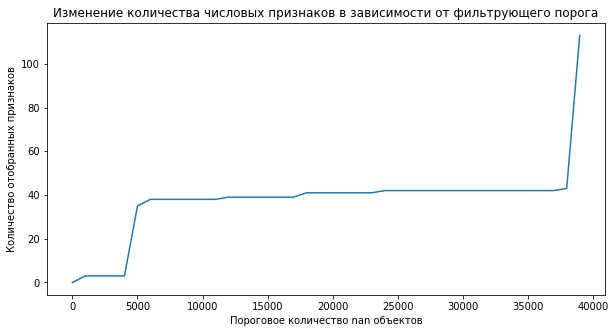

In [10]:
feature_amount = []
for threshold in range(0, 40000, 1000):
    nan_counter = num_data.isna().sum(axis = 0)
    f_amount = len(nan_counter[nan_counter < threshold])
    feature_amount.append(f_amount)

plt.figure(figsize = (10, 5))
plt.plot(range(0, 40000, 1000), feature_amount)
plt.title('Изменение количества числовых признаков в зависимости от фильтрующего порога')
plt.xlabel('Пороговое количество nan объектов')
plt.ylabel('Количество отобранных признаков')
plt.show()

In [11]:
NUM_THRESHOLD = 25000

In [12]:
nan_count = num_data.isna().sum(axis = 0).to_frame(name = 'count')
useful_num_featues = nan_count[nan_count['count'] < NUM_THRESHOLD].index

num_data = num_data[useful_num_featues]

In [13]:
print('Итоговое количество отобранных числовых признаков:', num_data.shape[1])

Итоговое количество отобранных числовых признаков: 42


**Аналогично подберем порог для категориальных признаков**

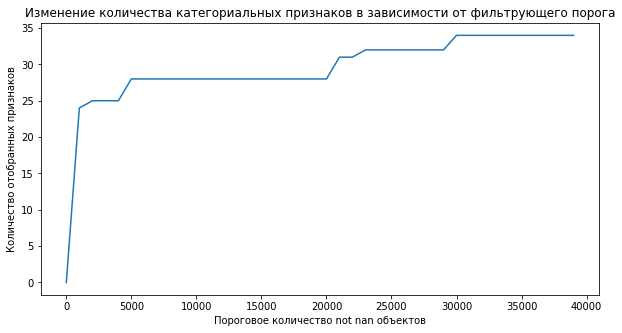

In [14]:
feature_amount = []
for threshold in range(0, 40000, 1000):
    nan_counter = cat_data.isna().sum(axis = 0)
    f_amount = len(nan_counter[nan_counter < threshold])
    feature_amount.append(f_amount)

plt.figure(figsize = (10, 5))
plt.plot(range(0, 40000, 1000), feature_amount)
plt.title('Изменение количества категориальных признаков в зависимости от фильтрующего порога')
plt.xlabel('Пороговое количество not nan объектов')
plt.ylabel('Количество отобранных признаков')
plt.show()

Обработаем все категориальные признаки

### Разбиение данных

In [15]:
full_data = pd.concat([num_data, cat_data, churn_data['label']], axis = 1)
full_data.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,label
0,3052.0,NaN,NaN,480.0,600.0,20.0,480.0,200.00,0.0,82752.0,0.0,2.907926,NaN,NaN,34,NaN,716008.0,0.0,14599.92,5.0,32.0,NaN,144.0,144.0,-1209960.0,1660.0,66.0,NaN,4.0,0.0,326915.0,604276.0,NaN,0.0,9.0,389396.0,2313888.0,28.0,599532.0,0.0,0.0,NaN,NaN,NESt0G8EIb,AERks4l,NaN,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,NaN,NaN,EkHG,9_Y1,k13i,09_Q,IYzP,GjJ35utlTa_GNSvxxpb9ju,kIsH,uKAI,L84s,JBfYVit4g8,NaN,NaN,NaN,TDctq2l,KmRo,cJvF,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,False
1,1813.0,7.0,636.0,212.0,265.0,2.0,128.0,166.56,0.0,2706120.0,0.0,5.870327,27.0,3.0,128,0.0,1661128.0,0.0,67529.09,25.0,10.0,32289.0,80.0,72.0,417932.0,1025.0,66.0,24912.0,40.0,0.0,1934460.0,349568.0,205.0,0.0,18.0,735.0,6502680.0,14.0,364182.0,0.0,0.0,276.0,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,NaN,JDd6,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,uKAI,L84s,XfqtO3UdzaXh_,NaN,I_mbgcr,NaN,XTbqizz,qMoY,cJvF,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,False
2,1953.0,7.0,448.0,176.0,220.0,0.0,72.0,311.76,0.0,4698780.0,0.0,5.981628,18.0,3.0,166,245.0,3025152.0,0.0,85266.00,35.0,0.0,53388.0,40.0,48.0,-124655.2,590.0,78.0,7218.0,36.0,0.0,3148410.0,1086210.0,400.0,0.0,27.0,0.0,10569040.0,18.0,0.0,0.0,0.0,NaN,NaN,FoxgUHSK8h,LrdZy8QqgUfkVShG,NaN,taul,1K8T,TyGl,fhk21Ss,nQUveAzAF7,NaN,NaN,dnwD,9_Y1,mTeA,VpdQ,hAFG,7M47J5GA0pTYIFxg5uy,kIsH,uKAI,L84s,4kVnq_T26xq1p,NaN,NaN,NaN,pMWBUmQ,qLXr,UYBR,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,False
3,1533.0,7.0,4.0,332.0,415.0,0.0,144.0,220.08,5.0,864384.0,0.0,5.108097,9.0,NaN,30,0.0,2642240.0,0.0,74107.20,10.0,2.0,NaN,32.0,32.0,378473.6,1435.0,24.0,693.0,NaN,8.0,7066700.0,650390.0,5.0,0.0,0.0,0.0,9676200.0,108.0,253284.0,0.0,0.0,NaN,NaN,vNEvyxLp3Z,RO12,NaN,taul,1K8T,0Xwj,uoZk2Zj,LWyxgtXeJL,NaN,NaN,CwmB,F3hy,vzJD,VpdQ,IYzP,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,JC0e,cJvF,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,True
4,686.0,7.0,0.0,160.0,200.0,2.0,48.0,278.00,0.0,4364880.0,0.0,0.650716,9.0,3.0,32,0.0,1440.0,0.0,171072.90,25.0,12.0,106455.0,32.0,8.0,142602.4,490.0,60.0,468.0,-28.0,0.0,3794460.0,642816.0,225.0,0.0,9.0,554414.0,10535200.0,24.0,2851284.0,0.0,0.0,NaN,NaN,4e7gUH7IEC,RO12,NaN,taul,1K8T,vSNn,kugYdIL,ZIXKpoNpqq,NaN,NaN,625Z,9_Y1,m_h1,sJzTlal,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,NGZXfGp,064o,cJvF,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,False


In [16]:
num_col_names = num_data.columns
cat_col_names = cat_data.columns

print('Число сырых числовых признаков', len(num_col_names))
print('Число сырых категориальных признаков', len(cat_col_names))

Число сырых числовых признаков 42
Число сырых категориальных признаков 38


In [17]:
X = full_data.drop(columns = ['label'])
y = full_data['label']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = SEED)

### Подбор  методов запонения пропусков в данных

Обзор стратегий заполнения: 
* https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
* https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e

Подходы для числовых данных:
* Simple imputer from sklearn
* [MICE (Multivariate imputation by chained equations)](https://impyute.readthedocs.io/en/latest/index.html)
* [DataWig](https://datawig.readthedocs.io/en/latest/source/userguide.html#step-by-step-examples) - *Слишком долго*
* [kNN](https://impyute.readthedocs.io/en/master/api/cross_sectional_imputation.html#impyute.imputation.cs.fast_knn)

Подходы для категориальных данных:
* [kNN](https://impyute.readthedocs.io/en/master/api/cross_sectional_imputation.html#impyute.imputation.cs.fast_knn)
* [Simple imputer with most frequent value](https://github.com/scikit-learn-contrib/sklearn-pandas#categoricalimputer)
* fillna + дополнительный признак

#### Числовые данные

**Simple mean imputer**

In [18]:
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
X_train_num_mean = imp.fit_transform(X_train_raw[num_col_names])
X_test_num_mean = imp.transform(X_test_raw[num_col_names])

X_train_num_mean = pd.DataFrame(X_train_num_mean, columns = num_col_names)
X_test_num_mean = pd.DataFrame(X_test_num_mean, columns = num_col_names)

In [288]:
print(X_train_num_mean.shape)
print(X_test_num_mean.shape)

(32000, 42)
(8000, 42)


In [289]:
print(X_train_num_mean.isnull().sum().sum())
print(X_test_num_mean.isnull().sum().sum())

0
0


**MICE**

In [20]:
# How MICE works: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

#Alternative realization in statsmodels
# https://www.statsmodels.org/dev/generated/statsmodels.imputation.mice.MICE.html
# MICE statsmodel using examples: https://programtalk.com/vs2/python/12423/statsmodels/statsmodels/imputation/tests/test_mice.py/

In [21]:
# %%time
## Не дождался
# X_train_num_mice = mice(X_train_raw[num_col_names])
# X_test_num_mice = mice(X_test_raw[num_col_names])

**DataWig**

In [22]:
# # Очень долго, обрабатывается по одному столбцу за итерацию
# X_train_num_dw = None
# X_test_num_dw = None

**kNN (fast-Knn from impyute)**

In [285]:
%%time
#10 min
X_train_num_knn = fast_knn(X_train_raw[num_col_names], k = 5)
X_test_num_knn = fast_knn(X_test_raw[num_col_names], k = 5)

X_train_num_knn.to_csv('./Data/X_train_num_knn', index_label = False)
X_test_num_knn.to_csv('./Data/X_test_num_knn', index_label = False)

CPU times: user 9min 35s, sys: 836 ms, total: 9min 36s
Wall time: 9min 35s


In [290]:
X_train_num_knn = pd.read_csv('./Data/X_train_num_knn')
X_test_num_knn = pd.read_csv('./Data/X_test_num_knn')

In [291]:
print(X_train_num_knn.shape)
print(X_test_num_knn.shape)

(32000, 42)
(8000, 42)


In [292]:
print(X_train_num_knn.isnull().sum().sum())
print(X_test_num_knn.isnull().sum().sum())

0
0


#### Категориальные данные

**kNN**

In [25]:
# Article: https://towardsdatascience.com/the-use-of-knn-for-missing-values-cf33d935c637
# Code implementation: https://gist.github.com/YohanObadia/b310793cd22a4427faaadd9c381a5850

In [26]:
# X_train_cat_knn = None 
# X_test_cat_knn = None 

**Categorical imputer**

In [27]:
imp = DataFrameImputer()
X_train_cat_freq = imp.fit_transform(X_train_raw[cat_col_names]).reset_index(drop = True)
X_test_cat_freq = imp.transform(X_test_raw[cat_col_names]).reset_index(drop = True)

In [293]:
print(X_train_cat_freq.shape)
print(X_test_cat_freq.shape)

(32000, 38)
(8000, 38)


In [294]:
print(X_train_cat_freq.isnull().sum().sum())
print(X_test_cat_freq.isnull().sum().sum())

0
0


**Fillna + additional feature**

In [226]:
def fillna_imputer(df):
    column_names = df.columns.to_list()
    result = pd.DataFrame()
    for name in column_names:
#         print(name)
        result[name] = df[name].fillna(value = 'Nan')
        result[name + '_bool'] = df[name].isna()
    return result.reset_index(drop = True)

In [227]:
X_train_cat_fillna = fillna_imputer(X_train_raw[cat_col_names])
X_test_cat_fillna = fillna_imputer(X_test_raw[cat_col_names])

In [295]:
print(X_train_cat_fillna.shape)
print(X_test_cat_fillna.shape)

(32000, 76)
(8000, 76)


In [296]:
print(X_train_cat_fillna.isnull().sum().sum())
print(X_test_cat_fillna.isnull().sum().sum())

0
0


#### Генерирование наборов данных с различными стратегиями заполнения. Кодирование

In [297]:
num_data_dict = {'mean': (X_train_num_mean, X_test_num_mean), 
                 'knn': (X_train_num_knn, X_test_num_knn)}
cat_data_dict = {'freq': (X_train_cat_freq , X_test_cat_freq),
                 'fillna': (X_train_cat_fillna, X_test_cat_fillna)}

In [299]:
#Cоберем в словарь типа key: (train, test) различные комбинации числовых/категориальных данных

data_dict = {}

for keys_combination in itertools.product( list(num_data_dict.keys()), list(cat_data_dict.keys())):
    print(keys_combination)
    data_dict[keys_combination[0] + '_' + keys_combination[1]] = (pd.concat([num_data_dict[keys_combination[0]][0],
                                                                                cat_data_dict[keys_combination[1]][0]], axis = 1),
                                                                      pd.concat([num_data_dict[keys_combination[0]][1],
                                                                                cat_data_dict[keys_combination[1]][1]], axis = 1)
                                                                     )                                                                    


('mean', 'freq')
('mean', 'fillna')
('knn', 'freq')
('knn', 'fillna')


In [300]:
data_dict.keys()

dict_keys(['mean_freq', 'mean_fillna', 'knn_freq', 'knn_fillna'])

In [301]:
print(data_dict['mean_freq'][0].shape)
print(data_dict['mean_freq'][1].shape)

(32000, 80)
(8000, 80)


Использование разных моделей обучения подразумевает  различные варианты кодирования категориальных данных.<br> Для логистической регресси воспользуемся One-Hot encoding, для нелинейных моделей используем CatBoostEncoder. 

В дальнейшем, после определения оптимального входного датасета, подберем опитмальный способ кодирования категориальных признаков.

In [302]:
data_encoders_dict = {}

In [303]:
# ohe_encoder = ce.OneHotEncoder(return_df=False) # Не влезает в память, напишем функцию вручную

Подготовим набор данных для линейных моделей (One Hot Encoding)

In [304]:
print('Типы данных в наборах:', data_dict['mean_freq'][0].dtypes.unique())

Типы данных в наборах: [dtype('float64') dtype('O')]


In [305]:
############################################
############################################

In [306]:
data_dict.keys()

dict_keys(['mean_freq', 'mean_fillna', 'knn_freq', 'knn_fillna'])

In [307]:
A = data_dict['knn_freq'][0]
B = data_dict['knn_freq'][1]

In [308]:
A

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,399.000000,0.000000,0.000000,132.00000,165.000000,4.000000,136.000000,330.080000,0.000000,1.455798e+06,0.000000,5.669302,9.000000,3.000000,20.0,0.000000,0.000000e+00,0.000000,104998.800000,15.000000,12.000000,0.000000,40.000000,0.000000,75392.0,550.000000,24.000000,0.000000,-8.000000,0.000000,5.104950e+05,2.908820e+06,0.000000,0.000000,18.00000,1.209607e+06,1.022060e+07,6.00000,3.110418e+06,0.000000,0.000000,222.000000,r__I,DHevyx7IEC,eSGpMwS8zSGgq_trOpckZ5,SEuy,taul,1K8T,7wJ6,NldASpP,yLQX8HOoy1,yP09M03,smXZ,0AJi,9_Y1,YGOC,09_Q,zm5i,DHn_WUyBhW_whjA88g9bvA64_,kIsH,uKAI,Mtgm,UbxQ8lZ,KdSa,5zARyjR,eGzu,ORMRote,SMDf,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,LM8l689qOp,4n2X,ELof,szEZ,02N6s8f,R4y5gQQWY8OodqDV,am7c
1,2464.000000,7.000000,148.000000,348.00000,435.000000,4.000000,80.000000,286.960000,5.000000,5.966364e+06,0.000000,0.022217,9.000000,3.000000,36.0,49.000000,2.049032e+06,0.000000,66902.410000,15.000000,4.000000,23190.000000,56.000000,48.000000,123962.8,1030.000000,144.000000,103869.000000,12.000000,8.000000,3.897690e+06,3.566820e+05,1115.000000,0.000000,9.00000,6.739600e+04,1.044832e+07,84.00000,8.907840e+05,0.000000,0.000000,284.569178,r__I,DHerjIKQ76,RO12,SEuy,taul,1K8T,YVv3,qlhCyQp,CdPgMY1Z52,yP09M03,smXZ,xRBh,9_Y1,7WNq,VpdQ,zm5i,me75fM6ugJ,kIsH,7A3j,L84s,NhsEn4L,KdSa,5zARyjR,eGzu,kZJyVg2,V0Vw,cJvF,FzaX,mTPRCiV,oslk,fi1YV0N,LM8l689qOp,4n2X,ELof,WqMG,RAYp,F2FyR07IdsN7I,am7c
2,1321.753276,6.805542,1252.544483,232.28966,287.378843,4.519499,95.549766,224.656382,0.700538,2.585601e+06,0.162272,5.735741,14.824777,4.181432,8.0,101.352064,1.492013e+06,0.520375,103266.815026,19.635227,8.444815,97551.340248,60.685794,66.025777,-2078516.0,908.123221,59.078478,28362.663232,-18.000000,3.447629,2.290719e+06,4.357513e+05,1392.935509,0.058155,11.75303,3.003950e+05,6.194629e+06,38.56592,4.846283e+05,0.006809,0.603821,222.000000,r__I,CEat0G8rTN,RO12,SEuy,taul,1K8T,wOc1,ZtMq7Fq,Nu1b2Lyme0,yP09M03,smXZ,pKvD,9_Y1,e7QV,VpdQ,IYzP,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,KdSa,5zARyjR,eGzu,7WwCtIM,L34u,cJvF,FzaX,lbrVHK6,oslk,_sz_44J,LM8l689qOp,4n2X,ELof,fKCe,RAYp,F2FyR07IdsN7I,am7c
3,1321.753276,6.805542,1252.544483,232.28966,287.378843,4.519499,95.549766,224.656382,0.700538,2.585601e+06,0.162272,5.726982,14.824777,4.181432,10.0,101.352064,1.492013e+06,0.520375,103266.815026,19.635227,8.444815,97551.340248,60.685794,66.025777,-624784.0,908.123221,59.078478,28362.663232,-14.000000,3.447629,2.290719e+06,4.357513e+05,1392.935509,0.058155,11.75303,3.003950e+05,6.194629e+06,38.56592,4.846283e+05,0.006809,0.603821,218.837470,r__I,V8lt0G8rTN,RO12,SEuy,taul,1K8T,0Xwj,HPUptnj,lGXpFd_2Rf,yP09M03,smXZ,98wF,HLqf,k13i,09_Q,IYzP,me75fM6ugJ,sBgB,uKAI,Mtgm,NhsEn4L,KdSa,5zARyjR,eGzu,7WwOAni,R9hg,UYBR,FzaX,hP0RwBA,oslk,Z_EqDjb,LM8l689qOp,4n2X,ELof,fKCe,RAYp,F2FyR07IdsN7I,am7c
4,385.000000,0.000000,0.000000,192.00000,240.000000,4.000000,80.000000,104.960000,0.000000,6.807120e+06,0.000000,4.726554,9.000000,3.000000,18.0,0.000000,1.743016e+06,0.000000,136960.200000,5.000000,10.000000,834.000000,48.000000,32.000000,121719.2,750.000000,96.000000,0.000000,-28.000000,8.000000,1.922025e+06,9.574600e+05,0.000000,6.000000,9.00000,5.550300e+05,1.036912e+07,24.00000,1.901382e+06,0.000000,0.000000,168.000000,r__I,bZkvyxLkBI,RO12,SEuy,taul,1K8T,lK27,q6YpzLh,itSGh3t,yP09M03,smXZ,SAaL,9_Y1,_r21,VpdQ,zm5i,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,KdSa,5zARyjR,eGzu,kZJyVg2,RYv4,cJvF,FzaX,efgVzos,oslk,OvOQls0,LM8l689qOp,4n2X,ELof,xb3V,RAYp,F2FyR07IdsN7I,am7c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [309]:
B

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,756.000000,7.000000,2168.000000,136.000000,170.000000,0.000000,8.000000,230.480000,0.000000,2.094834e+06,0.000000,0.483871,18.000000,3.961326,132.0,28.000000,4.838064e+06,0.000000,230973.600000,10.000000,0.00000,83080.885808,32.000000,56.000000,174282.0,480.000000,30.000000,7470.000000,-10.723253,0.00000,7.374050e+06,6.613800e+04,600.000000,0.000000,9.000000,0.000000e+00,1.053824e+07,38.000000,0.000000e+00,0.000000,0.000000,282.000000,r__I,a4vOj1dMWg,2Knk1KF,SEuy,taul,1K8T,lK27,UsSY9Q6,VKm8_AwS48,5YIkUea,smXZ,pU4J,9_Y1,DFSe,sJzTlal,lVqb,me75fM6ugJ,kIsH,g5HH,L84s,XfqtO3UdzaXh_,KdSa,PXYoYU2,eGzu,XTbPUYD,Zg_l,cJvF,FzaX,UF10FxM,oslk,BlJqCcD,jySVZNlOJy,4n2X,ELof,me1d,RAYp,55YFVY9,am7c
1,1312.552224,0.000000,0.000000,240.232545,0.000000,4.464898,0.000000,20.720000,0.000000,0.000000e+00,0.000000,2.885067,9.000000,4.188462,12.0,0.000000,0.000000e+00,0.000000,103388.465704,0.000000,0.00000,100125.567421,61.488495,0.000000,-319299.2,915.532798,0.000000,0.000000,4.000000,8.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,11.541385,2.892485e+05,0.000000e+00,0.000000,0.000000e+00,0.000000,7.000000,241.827022,r__I,9hRmfo875g,RO12,SEuy,taul,1K8T,ssAy,q6YpzLh,lGXpFd_2Rf,yP09M03,smXZ,FSno,9_Y1,Ew1Q,09_Q,IYzP,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,KdSa,5zARyjR,eGzu,uZL60aU,55ut,cJvF,FzaX,efgVzos,oslk,OvOQls0,LM8l689qOp,4n2X,ELof,wX53,RAYp,F2FyR07IdsN7I,am7c
2,1312.552224,6.738557,1214.775063,240.232545,296.582859,4.464898,98.940408,222.893265,0.748021,2.531297e+06,0.188776,1.923093,14.838248,4.188462,8.0,101.240522,1.476814e+06,0.568412,103388.465704,20.685512,8.50896,100125.567421,61.488495,66.991527,-2055860.0,915.532798,62.546187,26808.619208,-22.000000,3.71496,2.264506e+06,4.471403e+05,1324.849059,0.059175,11.541385,2.892485e+05,6.155738e+06,39.518266,4.912065e+05,0.006668,0.637866,272.973262,r__I,75lTmBtFkL,RO12,SEuy,taul,1K8T,TyGl,PTPYR4W,7aPrx0x,yP09M03,smXZ,ugzr,9_Y1,47ra,sJzTlal,IYzP,me75fM6ugJ,kIsH,uKAI,Mtgm,NhsEn4L,KdSa,5zARyjR,eGzu,TDcwKda,Kaoy,cJvF,FzaX,NlJA1m8,oslk,rUjzgmc,LM8l689qOp,4n2X,ELof,rgKb,RAYp,F2FyR07IdsN7I,am7c
3,357.000000,7.000000,432.000000,44.000000,55.000000,0.000000,56.000000,166.560000,0.000000,0.000000e+00,0.000000,2.160222,18.000000,3.000000,38.0,0.000000,0.000000e+00,0.000000,20099.910000,0.000000,0.00000,43398.000000,0.000000,0.000000,-203837.2,215.000000,0.000000,70533.000000,14.000000,0.00000,7.796500e+04,7.797400e+04,740.000000,0.000000,0.000000,0.000000e+00,2.183200e+05,8.000000,0.000000e+00,0.000000,0.000000,174.000000,r__I,DHeTmBftjz,RO12,SEuy,taul,1K8T,LFM_,TwRo8uU,n1zVHpT8NN,yP09M03,smXZ,jhY2,9_Y1,Gx0B,sJzTlal,IYzP,me75fM6ugJ,kIsH,uKAI,L84s,NhsEn4L,KdSa,5zARyjR,eGzu,mAjbk_S,15Fo,cJvF,FzaX,Oa96V3V,oslk,zFwT3Cb,LM8l689qOp,4n2X,ELof,Qu4f,RAYp,F2FyR07IdsN7I,am7c
4,1008.000000,7.000000,88.000000,152.000000,190.000000,4.000000,48.000000,255.600000,0.000000,6.208500e+06,0.000000,2.696432,9.000000,4.466423,130.0,0.000000,9.930080e+05,0.000000,153584.700000,25.000000,6.00000,94742.267057,32.000000,16.000000,248702.4,615.000000,78.000000,342.000000,8.000000,0.00000,2.067305e+06,1.036800e+06,230.000000,0.000000,27.000000,1.209600e+06,1.080340e+07,18.000000,1.261866e+06,0.000000,0.000000,266.478614,r__I,NQ5rEy7Rm6,g62hiBSaKg,SEuy,taul,1K8T,lK27,fhk21Ss,pNAbKh0,ewdVWAc,smXZ,YSVR,9_Y1,H9GL,sJzTlal,haYg,7M47J5GA0pTYIFxg5uy,kIsH,uKAI,L84s,cOJGGr4F_wga1,KdSa,xXoTUHO,eGzu,pMWZLMk,1wSn,cJvF,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,4n2X,ELof,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [310]:
def make_csr_ohe(x_train, x_test, columns):
    '''
    Function provide OneHot encoding of selected columns from mixed (categorical and non-categorical) dataframe.
    Return X_train, X_test in csr format and columns names.
    '''
#     print(x_train.shape, x_test.shape)
    # Sanity index drop
    x_train = x_train.reset_index(drop = True)
    x_test = x_test.reset_index(drop = True)
    
    x_full = pd.concat([x_train, x_test], axis = 0)
#     print(x_full)
    
    print('Nan values amount:', x_full.isnull().sum().sum())
    
    # Categorical data to coo matrix + make columns labels
    x_str = x_full.select_dtypes(exclude = ['float64'])
    x_str_ohe = pd.get_dummies(x_str, sparse = True, drop_first = True, columns = columns)
    ohe_labels = x_str_ohe.columns.to_list()
    x_str_ohe = x_str_ohe.sparse.to_coo()
    
    # Numerical data to coo matrix + make columns labels
    x_num = coo_matrix(x_full.select_dtypes(include = ['float64']))
    num_labels = x_full.select_dtypes(include = ['float64']).columns.to_list()
    
    column_names = num_labels + ohe_labels
    
    # Make final matrixm convert from coo to csr
    x_full = csr_matrix(hstack([x_num, x_str_ohe]))
#     print(type(x_full))
    x_train = x_full[:x_train.shape[0] ,:]
    x_test = x_full[x_train.shape[0]: ,:]
#     print(x_train.shape, x_test.shape)

    return (x_train, x_test, column_names)
    
    

In [311]:
%%time
data_ohe_dict = {}
for key in data_dict.keys():
    print(key)
    X_train, X_test = data_dict[key]
    ohe_columns = X_train.select_dtypes(exclude = ['float64']).columns.to_list()
    data_ohe_dict[key] = make_csr_ohe(X_train, X_test, ohe_columns)

mean_freq
Nan values amount: 0
mean_fillna
Nan values amount: 0
knn_freq
Nan values amount: 0
knn_fillna
Nan values amount: 0
CPU times: user 1min 15s, sys: 213 ms, total: 1min 16s
Wall time: 1min 15s


In [312]:
data_encoders_dict['ohe'] = data_ohe_dict

Подготовим набор для нелинейных моделей (CatBoost Encoding)

In [313]:
%%time
data_catboost_dict = {}
for key in data_dict.keys():
    print(key)
    X_train, X_test = data_dict[key]
    column_names = X_train.columns.to_list()
    catboost_columns = X_train.select_dtypes(exclude = ['float64']).columns.to_list()
    catboost_encoder = ce.CatBoostEncoder(cols = catboost_columns, random_state = SEED)
    X_train = catboost_encoder.fit_transform(X_train, y_train)
    X_test = catboost_encoder.fit(X_train, y_train)
    data_catboost_dict[key] = (X_train, X_test, column_names)

mean_freq
mean_fillna
knn_freq
knn_fillna
CPU times: user 1min 13s, sys: 55.7 ms, total: 1min 13s
Wall time: 1min 13s


In [314]:
data_encoders_dict['catboost'] = data_catboost_dict

In [316]:
# # Сохраним результаты в pkl файл
# # https://stackoverflow.com/questions/7100125/storing-python-dictionaries

# with open('./Data/data_dict.pkl', 'wb') as file:
#     pickle.dump(data_encoders_dict, file, protocol = pickle.HIGHEST_PROTOCOL)
    
# with open('./Data/data_dict.pkl', 'rb') as file:
#     data_encoders_dict = pickle.load(file)

#### Выбор оптимального набора даных для различных моделей

In [336]:
def train_model_cv_cl(X_train, y_train, X_test, params, 
                      encoder = None, 
                      model_type = 'sklearn', eval_metric = 'auc', 
                      sk_model = None, 
                      n_folds = 5,
                      n_estimators = 1000,
                      n_jobs = -1,
                      verbose = 250,
                      early_stopping_rounds = 200
                     ):
    if encoder is not None:
        X_train = encoder.fit_transform(X_train, y_train)
        X_test = encoder.transform(X_test)
    
    # set up scoring parameters for different models
    metrics_dict = {'auc': {'lgb': 'auc',         
                            'cat': 'AUC',
                            'sklearn': metrics.roc_auc_score,
                            'xgb': 'auc'}  
                   }
    cv_scores = []
    result_dict = {}
    pred_test = np.zeros(X_test.shape[0])
    pred_train = np.zeros(X_train.shape[0]) #collect all validation predictions over all folds
    
    fold_method = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = SEED)
    for fold_n, (dev_index, val_index) in enumerate(fold_method.split(X_train, y_train)):
        try:
            X_dev, X_val = X_train[dev_index], X_train[val_index]
            y_dev, y_val = y_train[dev_index], y_train[val_index]
            
        except: #if x data is pandas dataframes
            X_dev, X_val = X_train.iloc[dev_index], X_train.iloc[val_index]
            y_dev, y_val = y_train[dev_index], y_train[val_index]
            
        print(X_dev)
            
            
        
        if model_type == 'sklearn':
            model = sk_model(**params)
            model.fit(X_dev, y_dev)
            pred_y_val = model.predict_proba(X_val)[:, 1]
            pred_y_test = model.predict_proba(X_test)[:, 1]
            
            score = metrics_dict[eval_metric][model_type](y_val, pred_y_val)
            cv_scores.append(score)
            print(f'Fold {fold_n}. {eval_metric}: {score:.6f}.')
            print('')
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_dev, y_dev, eval_set = [(X_val, y_val)], 
                      eval_metric = metrics_dict[eval_metric][model_type],
                      verbose=verbose, 
                      early_stopping_rounds=early_stopping_rounds)
            pred_y_val = model.predict_proba(X_val)[:, 1]
            pred_y_test = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            dev_data = xgb.DMatrix(data = X_dev, label = y_dev)
            valid_data = xgb.DMatrix(data = X_val, label = y_val)            
            watchlist = [(dev_data, 'dev_data'), (valid_data, 'valid_data')]
            
            param = params #outside parameters
            param['eval_metric'] = metrics_dict[eval_metric][model_type] #add parameter from metric_dict
            
            model = xgb.train(dtrain = dev_data, evals=watchlist,
                              num_boost_round = n_estimators, 
                              early_stopping_rounds=early_stopping_rounds, 
                              verbose_eval=verbose, params=params)            
            pred_y_val = model.predict(xgb.DMatrix(X_val), ntree_limit=model.best_ntree_limit)
            pred_y_test = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric][model_type], **params,
                                      loss_function='Logloss', od_wait = early_stopping_rounds)
            model.fit(X_dev, y_dev, eval_set=(X_val, y_val), use_best_model=True, verbose=verbose)
            pred_y_val = model.predict(X_val)
            pred_y_test = model.predict(X_test)
            
        
        pred_train[val_index] += pred_y_val
        pred_test += pred_y_test
        cv_scores.append(metrics_dict[eval_metric]['sklearn'](y_val, pred_y_val))
        
    pred_test /= n_folds
    result_dict['predictions'] = pred_test
    result_dict['overall_val_predictions'] = pred_y_val
    result_dict['cv_scores'] = cv_scores
    
    print('CV mean score: {0:.6f}, std: {1:.6f}.'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    return result_dict

**Линейные модели**

In [318]:
# # Линейная модель
# LogisticRegression

# for key in data_dict.keys():
#     print(key)
#     X_train, X_test = data_dict[key]    
#     X_train = X_train.drop(columns = useless_features)
#     X_test = X_test.drop(columns = useless_features)
#     print(X_train.columns)
    
#     train_model_cv_cl(X_train, y_train, X_test, encoder = ohe_encoder, 
#                       model_type = 'sklearn', eval_metric = 'auc', sk_model = LogisticRegression(),
#                       params = None) 

In [319]:
X_train, X_test, column_names = data_encoders_dict['ohe']['mean_freq']

In [335]:
linear = LogisticRegression()
linear.fit(X_train, y_train)
linear.predict(X_test)

array([False, False, False, ..., False, False, False])

In [337]:
train_model_cv_cl(X_train, y_train, X_test, 
                  model_type = 'sklearn', eval_metric = 'auc', sk_model = LogisticRegression,
                  params = {}) 

  (0, 0)	399.0
  (0, 3)	132.0
  (0, 4)	165.0
  (0, 5)	4.0
  (0, 6)	136.0
  (0, 7)	330.08
  (0, 9)	1455798.0
  (0, 11)	5.669302
  (0, 12)	9.0
  (0, 13)	3.0
  (0, 14)	20.0
  (0, 18)	104998.8
  (0, 19)	15.0
  (0, 20)	12.0
  (0, 22)	40.0
  (0, 24)	75392.0
  (0, 25)	550.0
  (0, 26)	24.0
  (0, 28)	-8.0
  (0, 30)	510495.0
  (0, 31)	2908820.0
  (0, 34)	18.0
  (0, 35)	1209607.0
  (0, 36)	10220600.0
  (0, 37)	6.0
  :	:
  (25598, 444)	1.0
  (25598, 467)	1.0
  (25598, 644)	1.0
  (25598, 1083)	1.0
  (25598, 5699)	1.0
  (25598, 21869)	1.0
  (25598, 22275)	1.0
  (25598, 25901)	1.0
  (25598, 27849)	1.0
  (25598, 27921)	1.0
  (25598, 27941)	1.0
  (25598, 27949)	1.0
  (25598, 27960)	1.0
  (25598, 27976)	1.0
  (25598, 29378)	1.0
  (25598, 42663)	1.0
  (25598, 51951)	1.0
  (25598, 55622)	1.0
  (25598, 55633)	1.0
  (25598, 57405)	1.0
  (25598, 59539)	1.0
  (25598, 60773)	1.0
  (25598, 63444)	1.0
  (25598, 63457)	1.0
  (25598, 63469)	1.0


/home/grigoriy/anaconda3/envs/churn/lib/python3.6/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/grigoriy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN

**Нелинейные модели**